# Video integrated analysis
## Paths and packages

In [3]:
# Relative path, no need to change
script_path = '../script/'

# Absolute path, change it according to data locations
data_path = '../../data/'
feature_path = '../../features/'

In [4]:
import numpy as np
import pandas as pd
import math
import cv2
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

## Modify videos into right frame rates

In [5]:
def avi_30_to_mp4_24(video):
    cap = cv2.VideoCapture(video)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(video.replace('.avi', '.mp4'),fourcc, 24.0, (640,480))

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            # write the flipped frame
            out.write(frame)

    #         cv2.imshow('frame',frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
for video in glob.glob(data_path + 'iotlab_open_*/capture*.seq/*.avi'):
    avi_30_to_mp4_24(video)

### Add labels

In [6]:
labels = pd.read_csv(data_path + 'iotlab_open_fridge/action_label_timestamps.csv')

In [77]:
def vectorize(data, column):
    vec = [0] * 240
    for j in range(len(data[['frame.time_relative']])):
        k = float(data[['frame.time_relative']].iloc[j])
        if k <= 30:
            i = int(k // 0.125)
            vec[i] += float(data[[column]].iloc[j])
    return vec

def peak_finder(vec):
    peaks, properties =  find_peaks(vec, height = np.std(vec)*1.5)
    peaks_y = [vec[i] for i in peaks]
    return peaks, peaks_y

def plot_filtered_vec(column, activity, df):
    fig, axes = plt.subplots(33, sharex=True, sharey=False, figsize=(25, 20))
    df_epi = pd.read_csv(data_path + 'iotlab_open_fridge/keypoint_episodes.csv')
    k = 0
    peak_li = []
    peaks_y_li = []
    for i in range(33):
        data = pd.read_csv(feature_path + activity + '/csv/deeplens_open_fridge_{}_filtered.pcap.csv'.format(i), sep = '|')
        vec = vectorize(data, column)
        peaks, peaks_y =  peak_finder(vec)
        peaks_y = [vec[i] for i in peaks]
        axes[k].plot(range(240), vec)
        axes[k].plot(peaks, peaks_y, "x")
        axes[k].vlines(df['open one door'][i] * 8, 0, 30000,  colors = "r", linestyles = "dashed")
        axes[k].vlines(df['open two doors'][i] * 8, 0, 30000, colors = "y", linestyles = "dashed")
        axes[k].vlines(df['shut down doors'][i] * 8, 0, 30000, colors = "b", linestyles = "dashed")
        # plot overlaps
        axes[k].axvspan(df['open one door'][i] * 8, df['shut down doors'][i] * 8, alpha=0.2, color='red')
        for index, row in df_epi.loc[df_epi['Index'] == i].iterrows():
            axes[k].axvspan(row['Start_ts']*8, row['End_ts']*8, alpha=0.2, color='blue')
        k += 1
        peak_li.append(peaks*0.125)
        peaks_y_li.append(np.array(peaks_y))

#     plt.suptitle('Plot by ' + column + ' of {}'.format(activity))
#     plt.suptitle('Plot by ' + column + ' of {}'.format(activity) + ' from Device')
    plt.xlabel('time / seconds')
    plt.xticks(range(0, 240, 16), [i / 8 for i in range(0, 240, 16)])
    plt.show()
    return peak_li, peaks_y_li

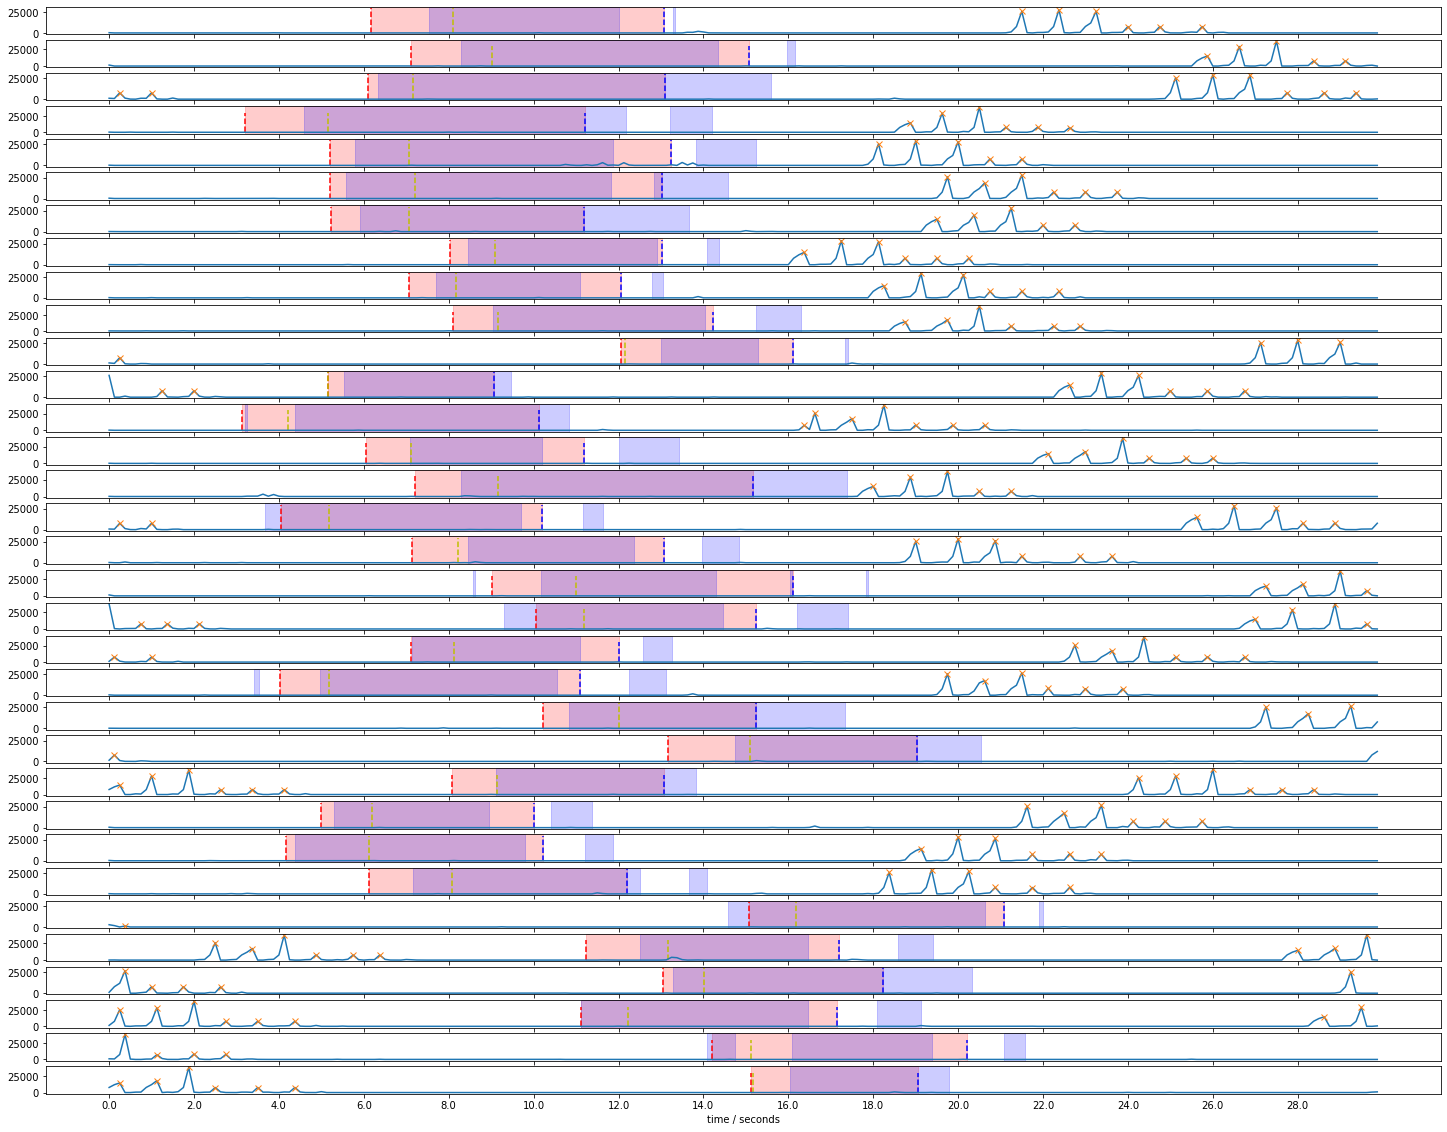

In [78]:
col = 'frame.len'
peak_li, peaks_y_li = plot_filtered_vec(col, 'iotlab_open_fridge', labels)

In [38]:
# single figure
def vectorize(data, column):
    vec = [0] * 240
    for j in range(len(data[['frame.time_relative']])):
        k = float(data[['frame.time_relative']].iloc[j])
        if k <= 30:
            i = int(k // 0.125)
            vec[i] += float(data[[column]].iloc[j])
    return vec

def peak_finder(vec):
    peaks, properties =  find_peaks(vec, height = np.std(vec))
    peaks_y = [vec[i] for i in peaks]
    return peaks, peaks_y

def plot_filtered_vec_dev(column, activity, dev, df):
    figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
#     fig, axes = plt.subplots(1, sharex=True, sharey=False, figsize=(25, 20))
#     df_epi = pd.read_csv(data_path + 'iotlab_open_' + dev + '/keypoint_episodes.csv')
    k = 0
    peak_li = []
    peaks_y_li = []

    data = pd.read_csv(feature_path + activity + '/csv/deeplens_open_' + dev + '_0_filtered.pcap.csv', sep = '|')
    vec = vectorize(data, column)
    peaks, peaks_y =  peak_finder(vec)
    peaks_y = [vec[i] for i in peaks]
    plt.plot(range(240), vec)
    plt.plot(peaks, peaks_y, "x", label='Traffic peak')
    plt.vlines(df['open door'][1] * 8, 0, np.max(peaks_y),  colors = "r", linestyles = "dashed", label='Open door')
#     plt.vlines(df['open two doors'][1] * 8, 0, 30000, colors = "y", linestyles = "dashed", label='Open two doors')
    plt.vlines(df['shut down door'][1] * 8, 0, np.max(peaks_y), colors = "b", linestyles = "dashed", label='Close door')
    plt.fill_between(range(240), vec, alpha=0.2, color='blue')
    # plot overlaps
#         axes[k].axvspan(df['open one door'][i] * 8, df['shut down doors'][i] * 8, alpha=0.2, color='red')
#         for index, row in df_epi.loc[df_epi['Index'] == i].iterrows():
#             axes[k].axvspan(row['Start_ts']*8, row['End_ts']*8, alpha=0.2, color='blue')
    peak_li.append(peaks*0.125)
    peaks_y_li.append(np.array(peaks_y))

#     plt.suptitle('Plot by ' + column + ' of {}'.format(activity))
#     plt.suptitle('Plot by ' + column + ' of {}'.format(activity) + ' from Device')
    plt.xlabel('time [s]')
    plt.ylabel('traffic volume [bps]')
    plt.xticks(range(0, 256, 16), [int(i / 8) for i in range(0, 256, 16)])
    max_y = int(np.max(peaks_y))
#     plt.yticks(range(0, max_y, int(max_y/6)), [(i / 1000) for i in range(0, max_y, int(max_y/6))])
    plt.yticks(range(0, 5001, 1000), [int(i / 1000) for i in range(0, 5001, 1000)])
    plt.legend()
#     plt.show()
    plt.savefig(activity + '_traffic.pdf', bbox_inches = 'tight', dpi=300)
    return peak_li, peaks_y_li

In [ ]:
col = 'frame.len'
plot_vec_ip(col, 'iotlab_open_fridge', '192.168.143.43', 'Fridge')
plot_vec_ip(col, 'iotlab_open_washer', '192.168.143.100', 'Washer')
plot_vec_ip(col, 'iotlab_open_dryer', '192.168.143.99', 'Dryer')
plot_vec_ip(col, 'iotlab_open_dishwasher', '192.168.143.76', 'Dishwasher')

In [33]:
import matplotlib
from matplotlib.pyplot import figure

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)

def plot_dev(dev):
    labels = pd.read_csv(data_path + 'iotlab_open_' + dev + '/action_label_timestamps.csv')
    col = 'frame.len'
    peak_li, peaks_y_li = plot_filtered_vec_dev(col, 'iotlab_open_' + dev, dev, labels)

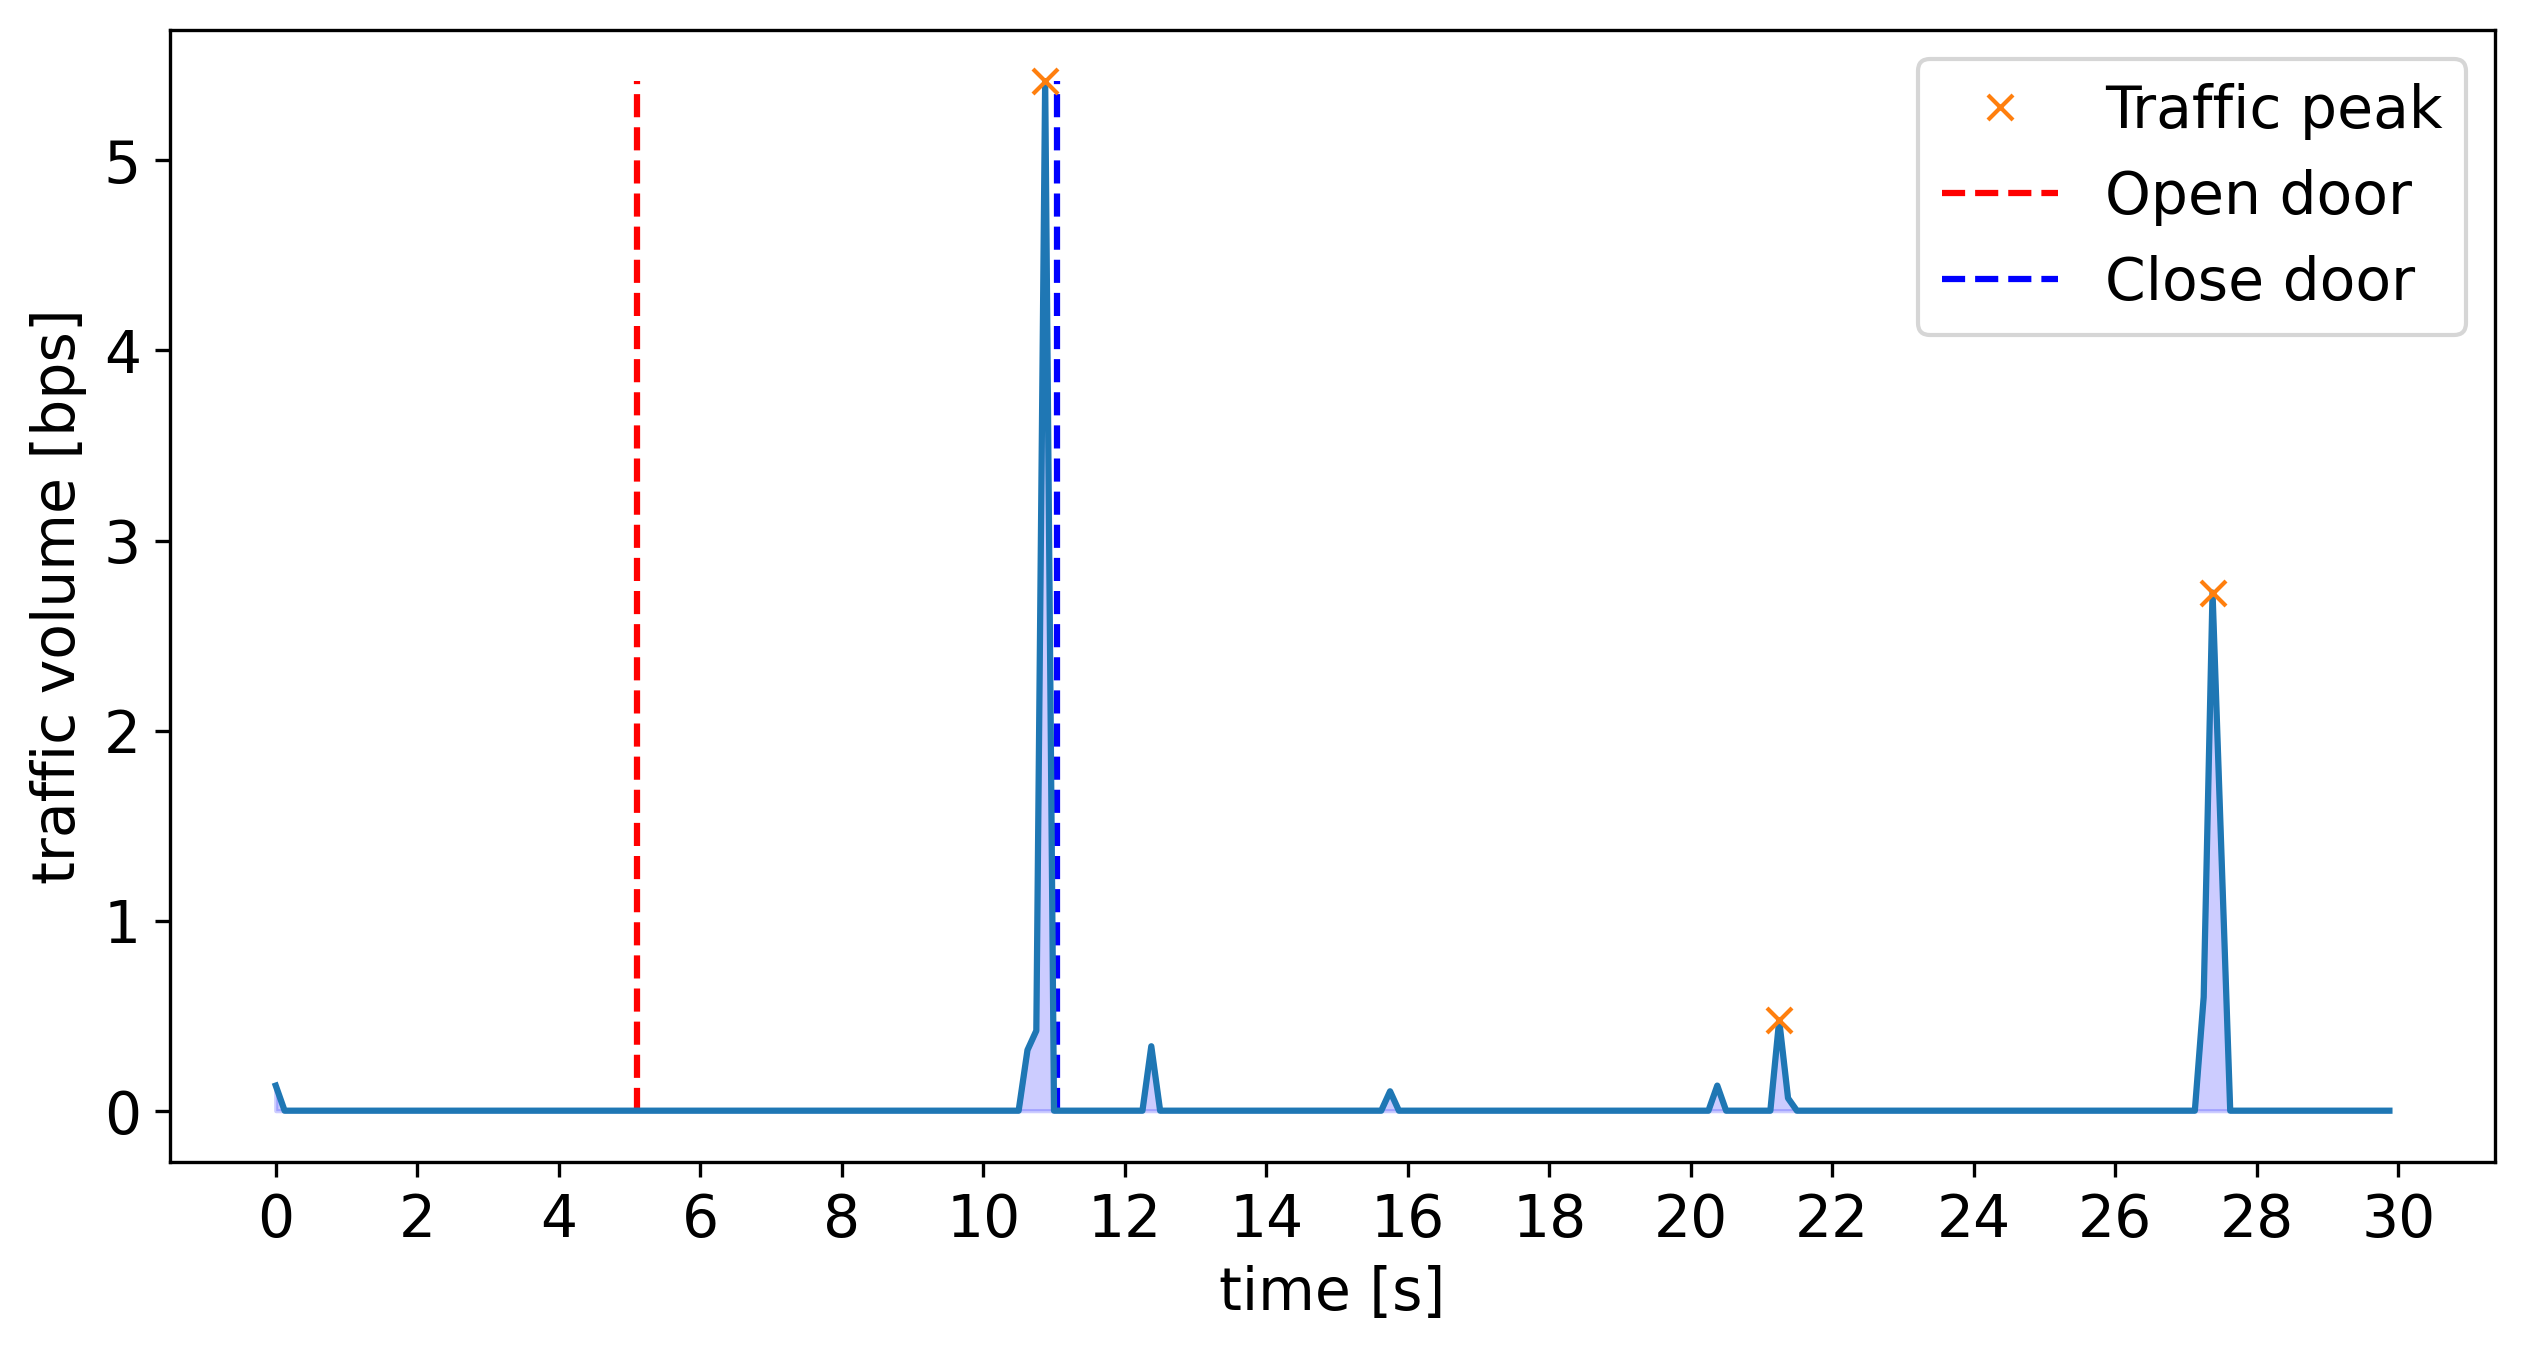

In [39]:
plot_dev('dishwasher')

In [17]:
df_peak = pd.DataFrame(peak_li)
df_peak.columns = ["peak_" + str(num) for num in range(12)]
df = pd.concat([labels, df_peak], axis=1)

for i, row in df.iterrows():
    for col in ["peak_" + str(num) for num in range(12)]:
        if(row["open one door"] >= row[col]):
            df.at[i,col] = row[col] + 30

In [18]:
df.to_csv(data_path + 'iotlab_open_fridge/action_label_peaks_timestamps.csv', index=False)

In [21]:
df_label_peaks = pd.read_csv(data_path + 'iotlab_open_fridge/action_label_peaks_timestamps.csv')

In [25]:
df_label_peaks.to_csv(data_path + 'iotlab_open_fridge/action_label_peaks_timestamps.csv', index=False)

In [23]:
cols = ["open one door", "open two doors", "shut down doors"]
for col in cols:
    df_label_peaks[col] = df_label_peaks[col].apply(lambda x: math.modf(float(x))[0] * 100.0 / 24 + math.modf(float(x))[1])

In [24]:
df_label_peaks

,capture number,open one door,open two doors,shut down doors,remarks,peak_0,peak_1,peak_2,peak_3,peak_4,peak_5,peak_6
0,0,6.708333,8.416667,13.291667,NaN,21.500,22.375,23.250,24.000,24.750,25.750,NaN
1,1,7.416667,9.083333,15.291667,NaN,25.875,26.625,27.500,28.375,29.125,30.250,31.000
2,2,6.416667,7.666667,13.375000,NaN,25.125,26.000,26.875,27.750,28.625,29.375,NaN
3,3,3.791667,5.625000,11.916667,NaN,18.875,19.625,20.500,21.125,21.875,22.625,NaN
4,4,5.833333,7.250000,13.958333,NaN,18.125,19.000,20.000,20.750,21.500,NaN,NaN
5,5,5.833333,7.875000,13.083333,NaN,19.750,20.625,21.500,22.250,23.000,23.750,NaN
6,6,5.916667,7.291667,11.750000,NaN,19.500,20.375,21.250,22.000,22.750,NaN,NaN
7,7,8.125000,9.375000,13.083333,NaN,16.375,17.250,18.125,18.750,19.500,20.250,NaN
8,8,7.250000,8.750000,12.208333,NaN,18.250,19.125,20.125,20.750,21.500,22.375,NaN
9,9,8.458333,9.666667,14.916667,NaN,18.750,19.750,20.500,21.250,22.250,22.875,30.250


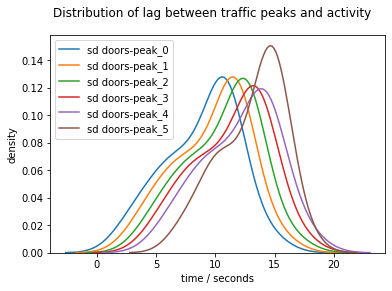

In [128]:
for col in ["peak_" + str(num) for num in range(6)]:
    sns.distplot(df_label_peaks[col] - df_label_peaks['shut down doors'], hist = False, kde = True, label = 'sd doors-' + col)
    
plt.suptitle('Distribution of lag between traffic peaks and activity')
plt.xlabel('time / seconds')
plt.ylabel('density')
plt.legend()
# plt.xticks(range(0, 240, 16), [i / 8 for i in range(0, 240, 16)])
plt.show()

In [27]:
def peak_finder(vec):
    peaks, properties =  find_peaks(vec, height = 500)
    peaks_y = [vec[i] for i in peaks]
    return peaks, peaks_y

def filter_by_ip(df, ip):
    return df.loc[df['ip.src'] == ip]
        
def plot_vec_ip(column, activity, ip, device):
    df = pd.read_csv(data_path + activity + '/action_label_timestamps.csv')
    fig, axes = plt.subplots(34, sharex=True, sharey=False, figsize=(25, 20))
    plt.ylabel('packet len / bytes')
    
    vec_li = []
    for i in range(34):
        data = pd.read_csv(data_path + activity + '/capture{}.seq'.format(i) 
                           + '/deeplens_{}_{}.pcap.csv'.format(activity.split('iotlab_')[-1], i), sep = '|')
        data_filtered = filter_by_ip(data, ip)
        vec = vectorize(data_filtered, column)
        vec_li.append(vec)
    
    ylim = np.array(vec_li).max()
    
    k = 0
    peak_li = []
    peaks_y_li = []
    for vec in vec_li:
        peaks, peaks_y =  peak_finder(vec)
        peaks_y = [vec[i] for i in peaks]
        axes[k].plot(range(240), vec)
        axes[k].set_ylim([min(vec) - max(vec)*0.1,ylim*1.2])
        axes[k].plot(peaks, peaks_y, "x")
        if len(df.columns.tolist()) == 6:
            axes[k].vlines(df['turn on device'][k] * 8, 0, ylim,  colors = "r", linestyles = "dashed")
            axes[k].vlines(df['open door'][k] * 8, 0, ylim, colors = "y", linestyles = "dashed")
            axes[k].vlines(df['shut down door'][k] * 8, 0, ylim, colors = "b", linestyles = "dashed")
            axes[k].vlines(df['turn off device'][k] * 8, 0, ylim, colors = "g", linestyles = "dashed")
            k += 1
        elif len(df.columns.tolist()) == 4:
            if df['open one door'][k] != 0 and df['open two doors'][k] != 0:
                axes[k].vlines(df['open one door'][k] * 8, 0, ylim,  colors = "r", linestyles = "dashed")
                axes[k].vlines(df['open two doors'][k] * 8, 0, ylim, colors = "y", linestyles = "dashed")
            if df['shut down doors'][k] != 0:
                axes[k].vlines(df['shut down doors'][k] * 8, 0, ylim, colors = "b", linestyles = "dashed")
            k += 1
        elif len(df.columns.tolist()) == 3:
            axes[k].vlines(df['open door'][k] * 8, 0, ylim,  colors = "r", linestyles = "dashed")
            axes[k].vlines(df['shut down door'][k] * 8, 0, ylim, colors = "b", linestyles = "dashed")
            k += 1
        peak_li.append(peaks*0.125)
        peaks_y_li.append(np.array(peaks_y))
    plt.suptitle('Plot by ' + column + ' of {}'.format(activity) + ' from ' + device)
    plt.xlabel('time / seconds')
    plt.xticks(range(0, 240, 16), [i / 8 for i in range(0, 240, 16)])
    plt.show()
    
    df_peak = pd.DataFrame(peak_li)
#     df_peak.columns = ["peak_" + str(num) for num in range(9)]
    df_label_peaks = pd.concat([df, df_peak], axis=1)
    if len(df.columns.tolist()) == 6:
        cols = ["turn on device", "open door", "shut down door", "turn off device"]
        for col in cols:
            df_label_peaks[col] = df_label_peaks[col].apply(lambda x: math.modf(float(x))[0] * 100.0 / 24 + math.modf(float(x))[1])
    df_label_peaks.to_csv(data_path + 'iotlab_open_dishwasher/action_label_peaks_timestamps.csv', index=False)
    return df_label_peaks

/Users/shinanliu/opt/miniconda3/lib/python3.7/site-packages/numpy-1.18.3-py3.7-macosx-10.9-x86_64.egg/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/shinanliu/opt/miniconda3/lib/python3.7/site-packages/numpy-1.18.3-py3.7-macosx-10.9-x86_64.egg/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


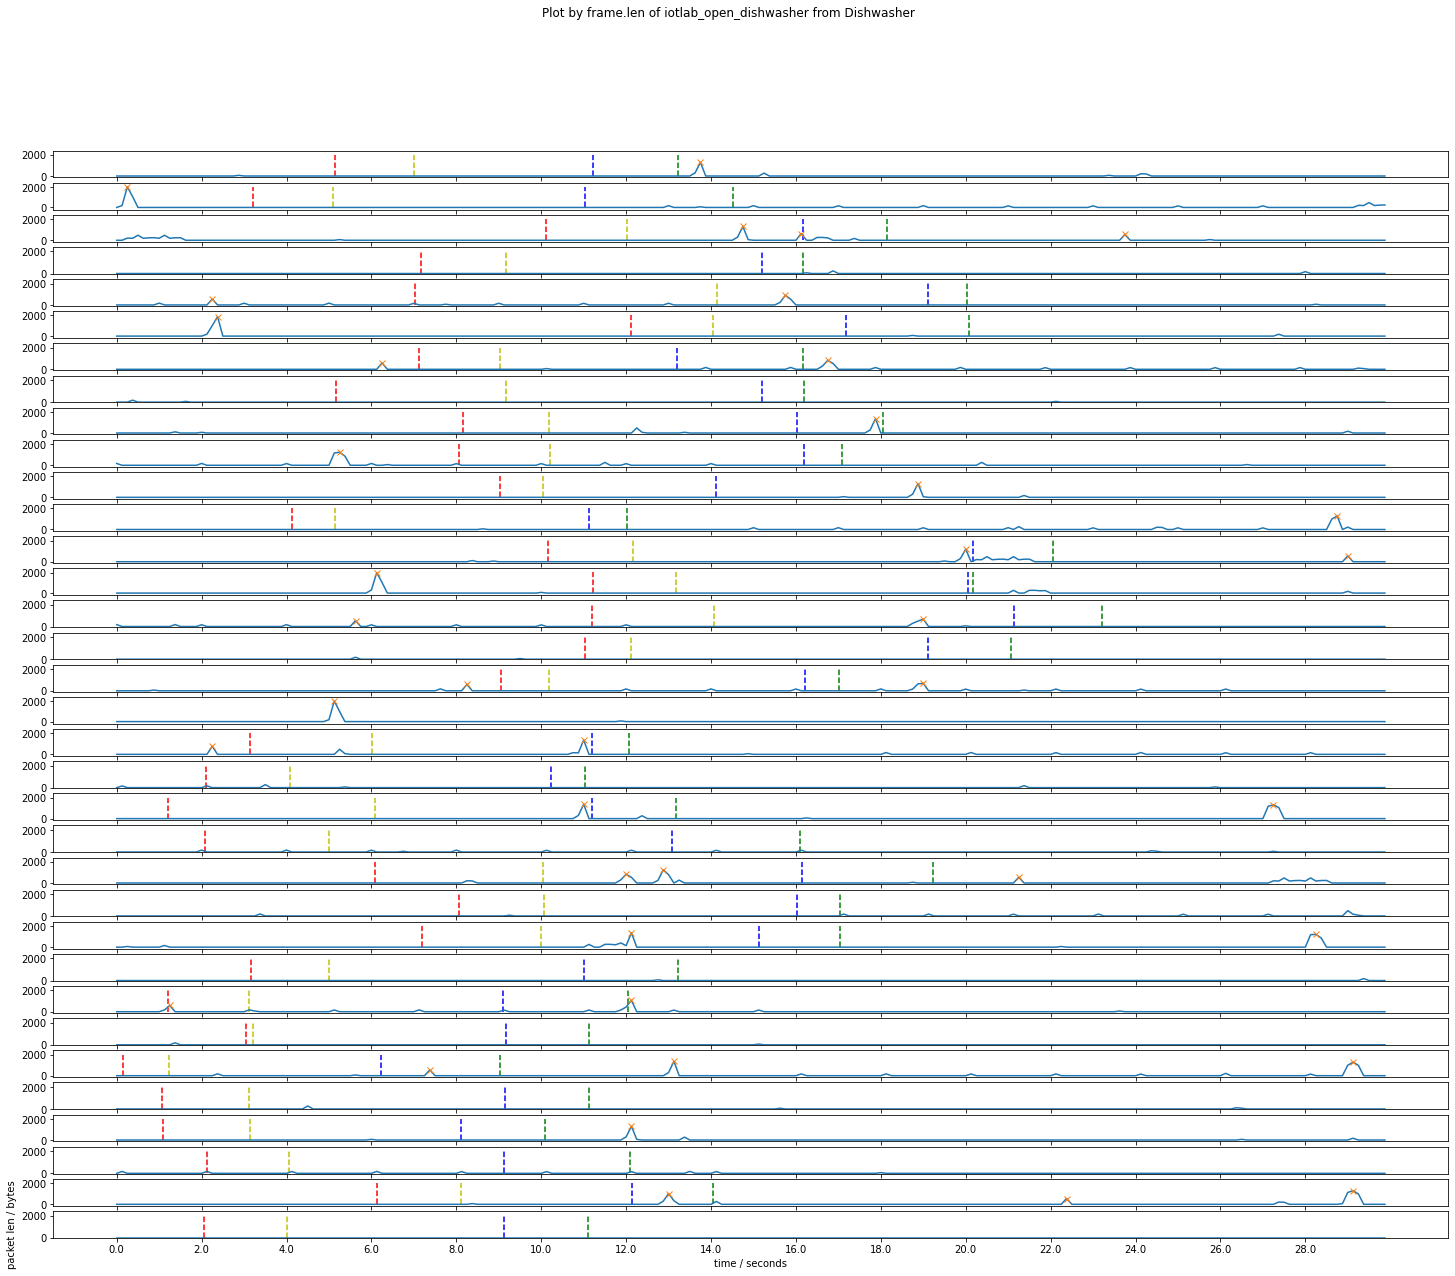

In [28]:
col = 'frame.len'
df_label_peaks = plot_vec_ip(col, 'iotlab_open_dishwasher', '192.168.143.76', 'Dishwasher')

In [29]:
df_label_peaks

,capture number,turn on device,open door,shut down door,turn off device,remarks,0,1,2
0,0,5.541667,7.041667,11.916667,13.916667,NaN,13.750,NaN,NaN
1,1,3.916667,5.416667,11.166667,16.166667,NaN,0.250,NaN,NaN
2,2,10.458333,12.083333,16.666667,18.583333,NaN,14.750,16.125,23.750
3,3,7.666667,9.708333,15.875000,16.708333,NaN,NaN,NaN,NaN
4,4,7.125000,14.583333,19.458333,20.083333,NaN,2.250,15.750,NaN
5,5,12.500000,14.208333,17.791667,20.291667,NaN,2.375,NaN,NaN
6,6,7.541667,9.083333,13.875000,16.666667,NaN,6.250,16.750,NaN
7,7,5.708333,9.750000,15.875000,16.791667,NaN,NaN,NaN,NaN
8,8,8.625000,10.750000,16.083333,18.208333,NaN,17.875,NaN,NaN
9,9,8.250000,10.875000,16.833333,17.375000,NaN,5.250,NaN,NaN


In [167]:
df_label_peaks.columns

Index([ 'capture number',  'turn on device',       'open door',
        'shut down door', 'turn off device',         'remarks',
                       0,                 1,                 2],
      dtype='object')

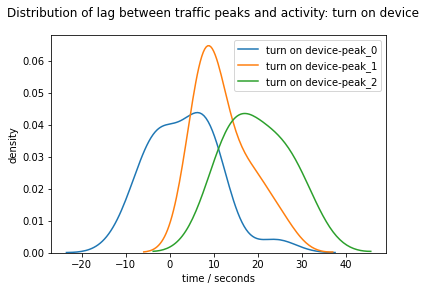

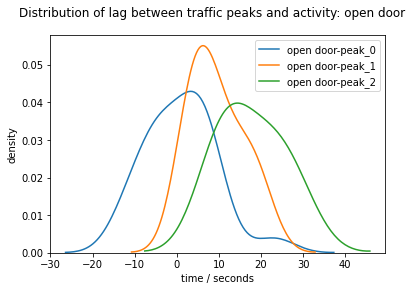

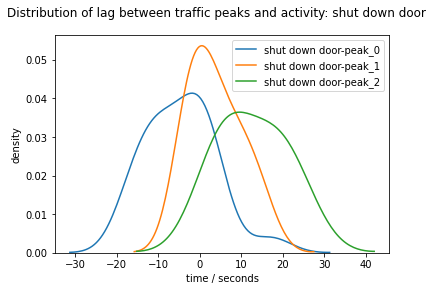

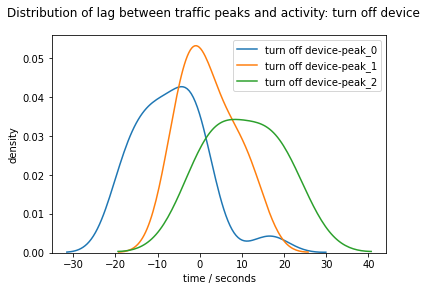

In [169]:
for act_col in ["turn on device", "open door", "shut down door", "turn off device"]:
    for col in [num for num in range(3)]:
        sns.distplot(df_label_peaks[col] - df_label_peaks[act_col], hist = False, kde = True, label = act_col + '-peak_' + str(col))

    plt.suptitle('Distribution of lag between traffic peaks and activity: ' + act_col)
    plt.xlabel('time / seconds')
    plt.ylabel('density')
    plt.legend()
    plt.show()

### Plot by it's own IP
#### Activities on fridge

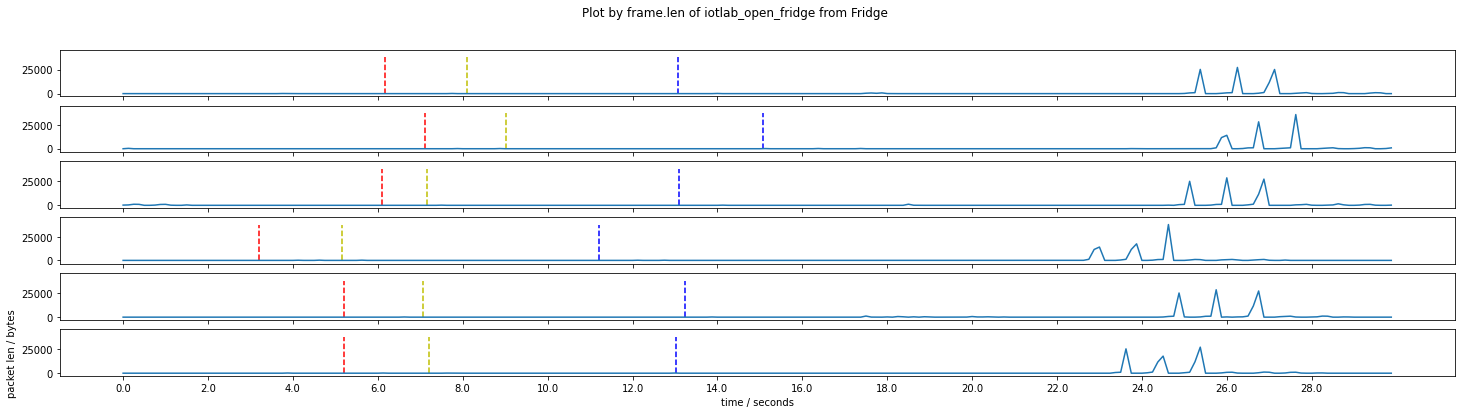

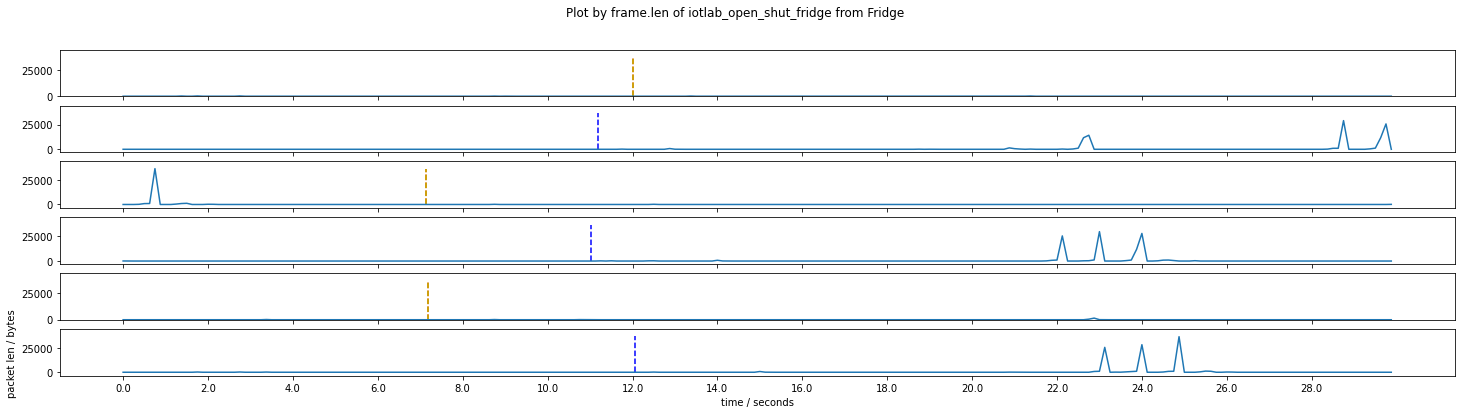

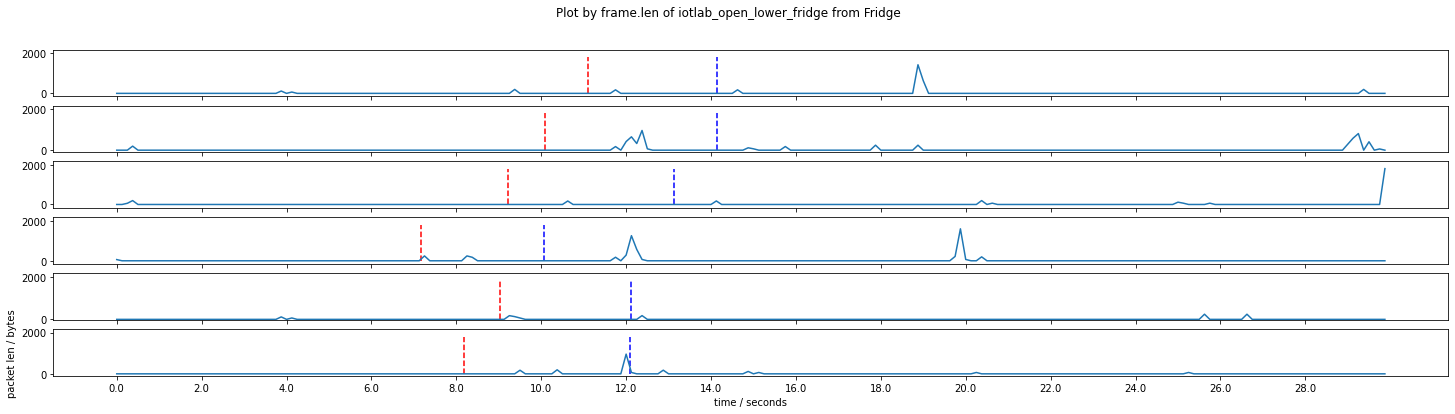

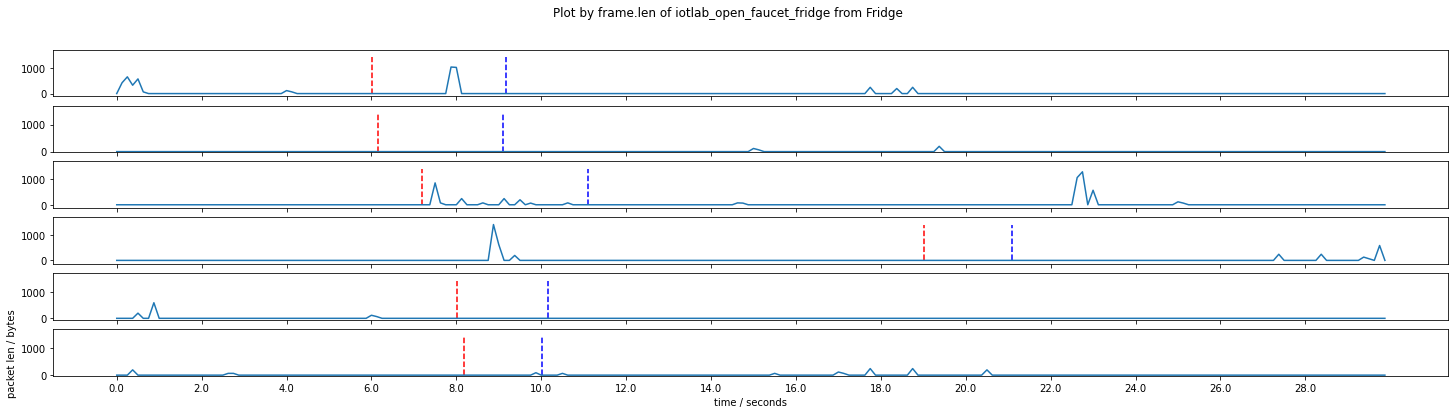

In [9]:
col = 'frame.len'
for activity in ['iotlab_open_fridge', 'iotlab_open_shut_fridge', 'iotlab_open_lower_fridge','iotlab_open_faucet_fridge']:
    plot_vec_ip(col, activity, '192.168.143.43', 'Fridge')

#### Activities on other devices

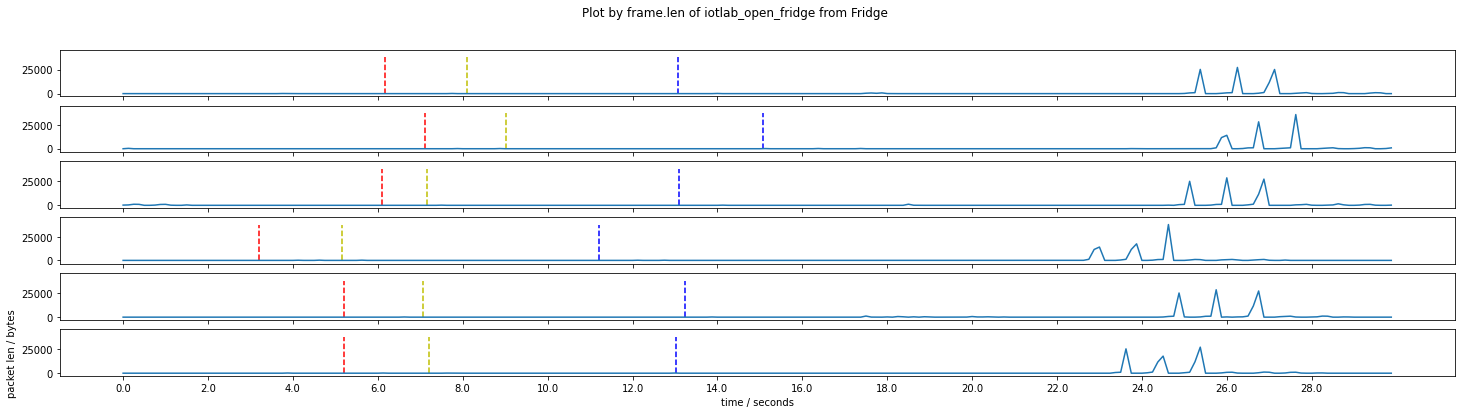

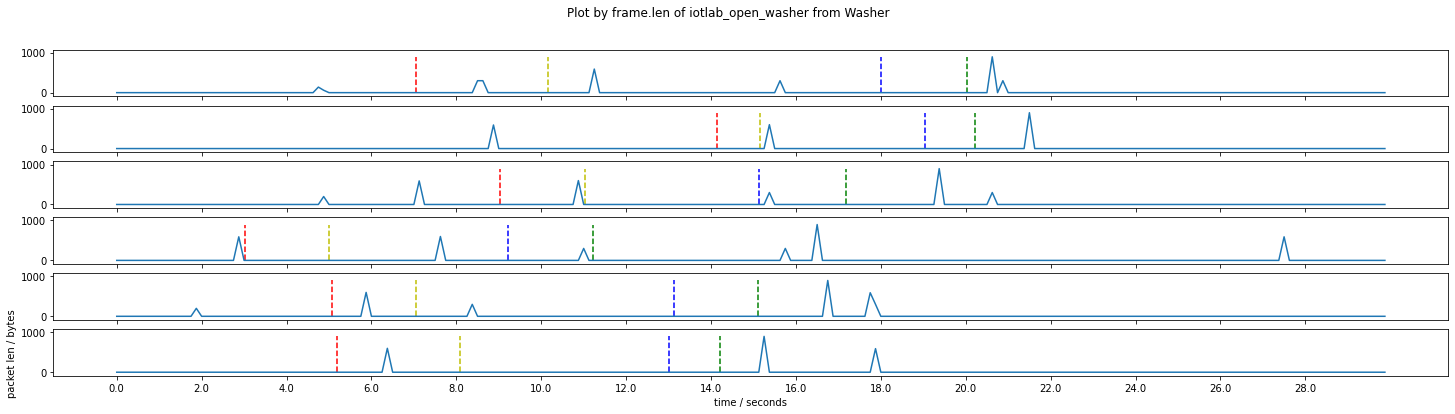

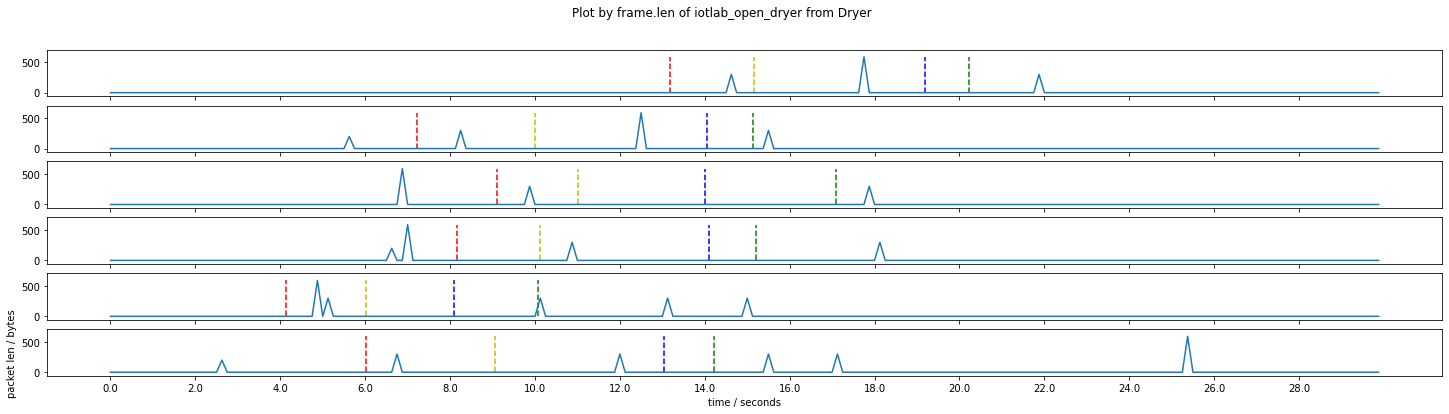

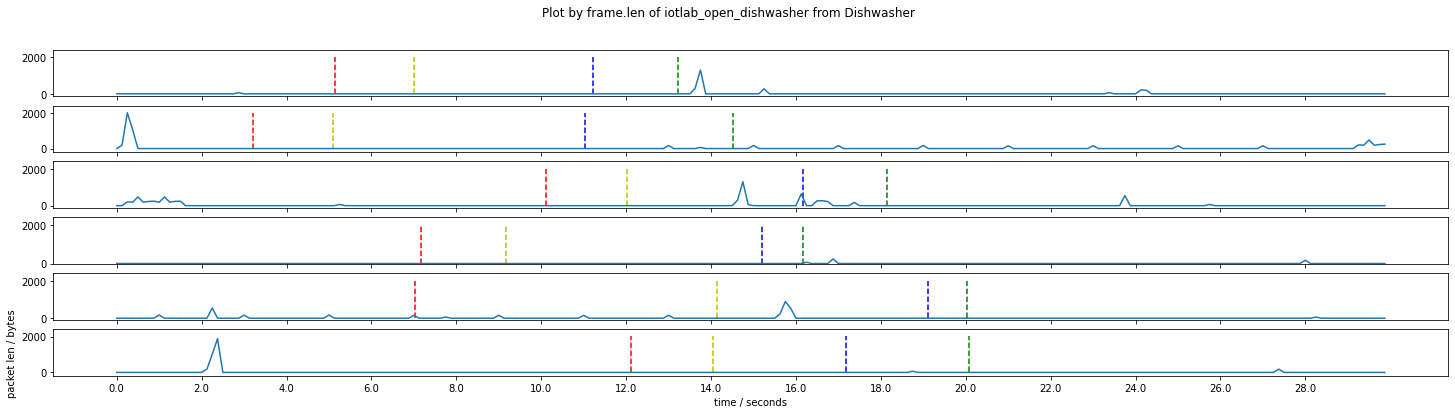

In [10]:
col = 'frame.len'
plot_vec_ip(col, 'iotlab_open_fridge', '192.168.143.43', 'Fridge')
plot_vec_ip(col, 'iotlab_open_washer', '192.168.143.100', 'Washer')
plot_vec_ip(col, 'iotlab_open_dryer', '192.168.143.99', 'Dryer')
plot_vec_ip(col, 'iotlab_open_dishwasher', '192.168.143.76', 'Dishwasher')

### Plot by IP of the camera
#### Different activities from Fridge

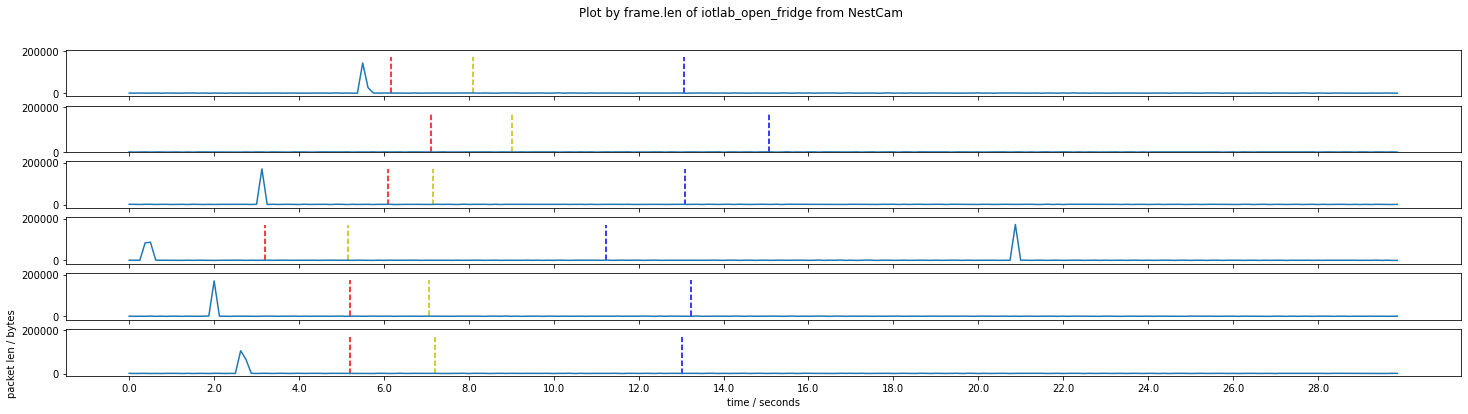

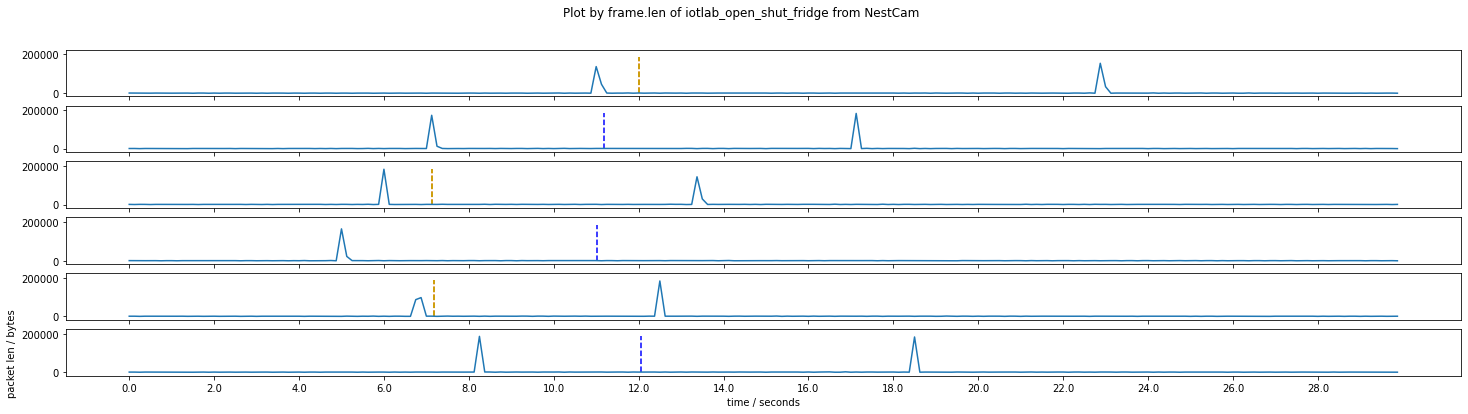

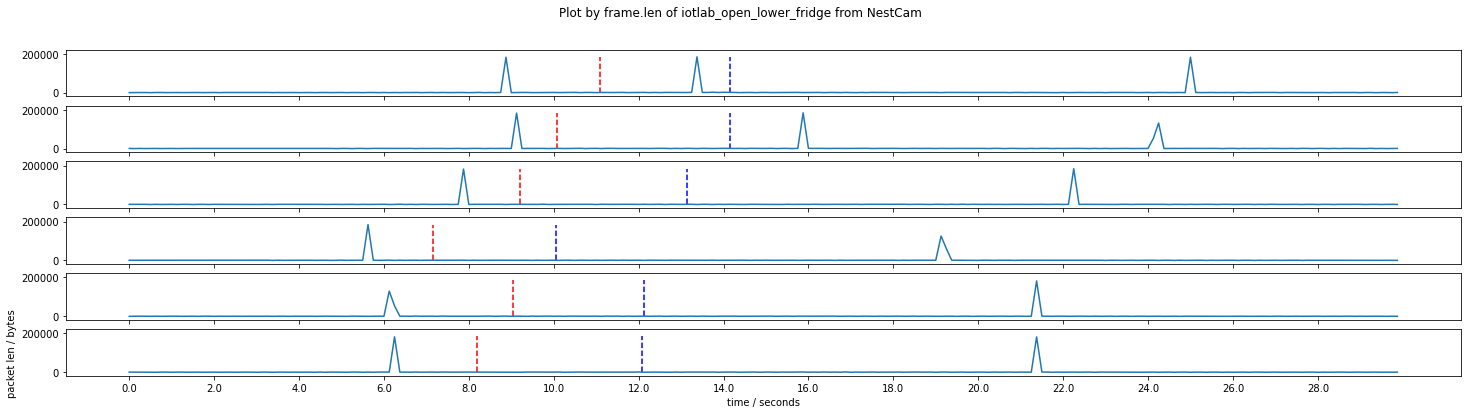

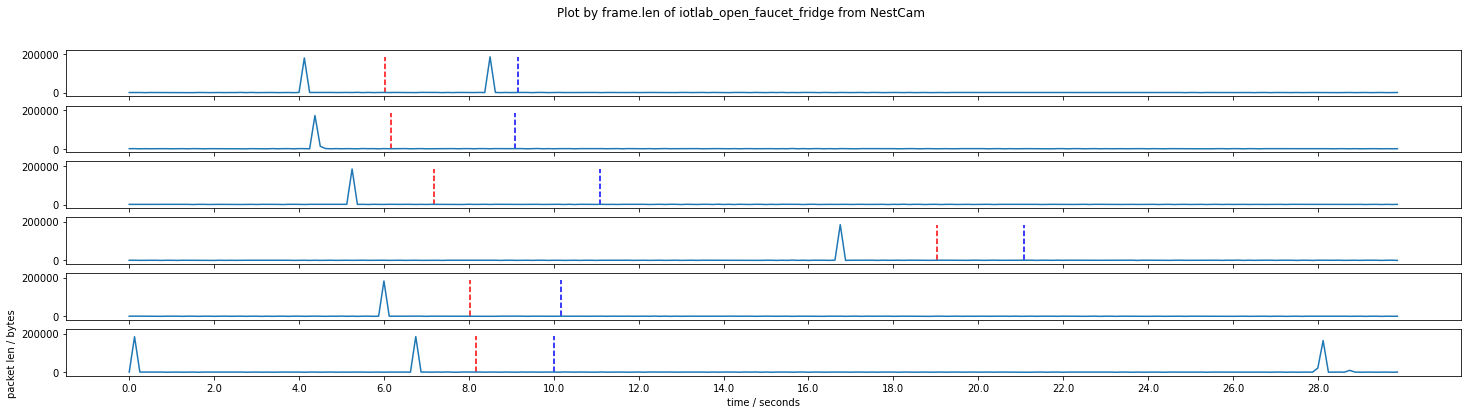

In [11]:
for activity in ['iotlab_open_fridge', 'iotlab_open_shut_fridge', 'iotlab_open_lower_fridge','iotlab_open_faucet_fridge']:
    plot_vec_ip(col, activity, '192.168.143.104', 'NestCam')

#### Same activity from different devices

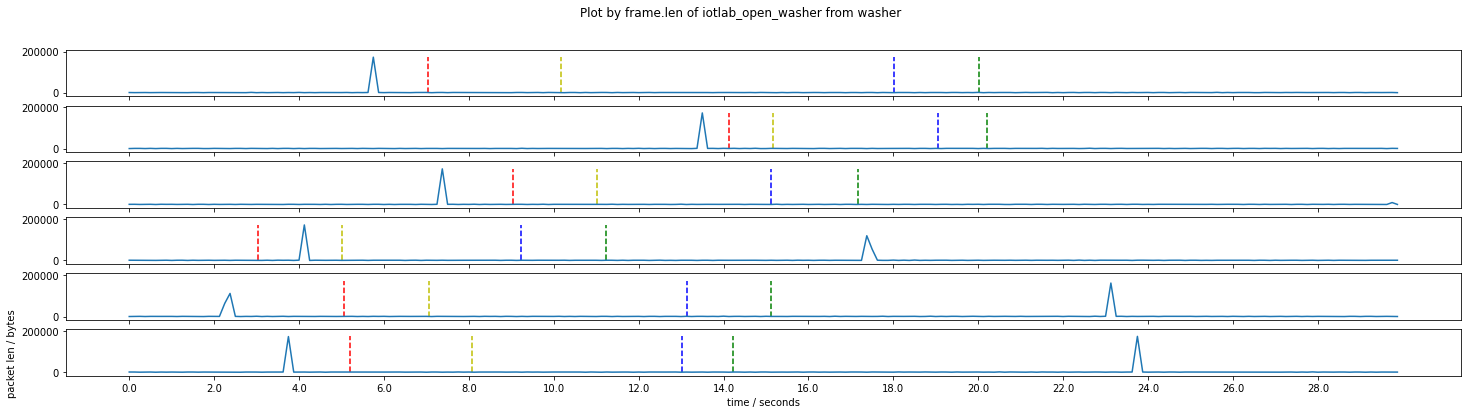

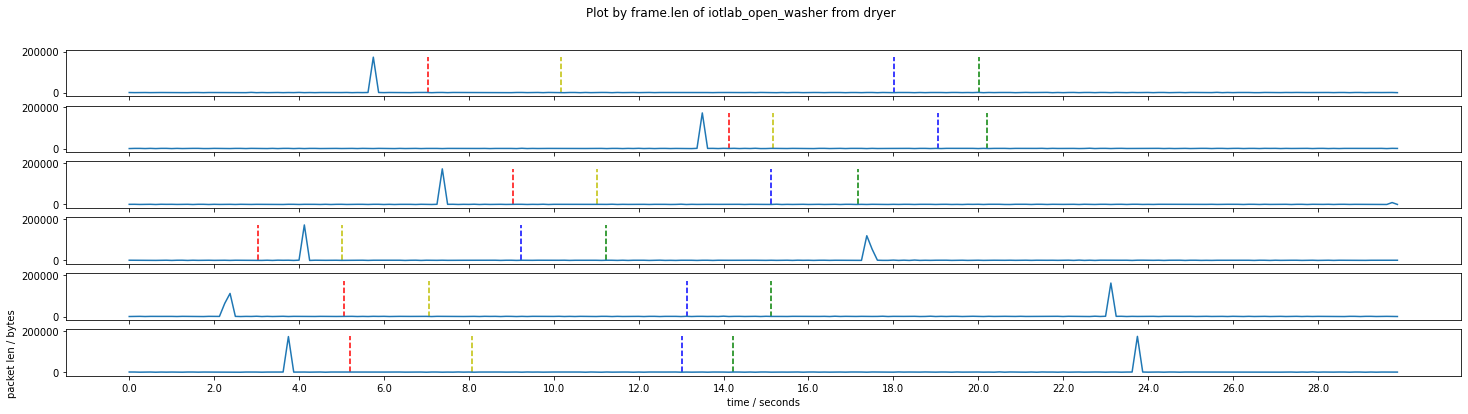

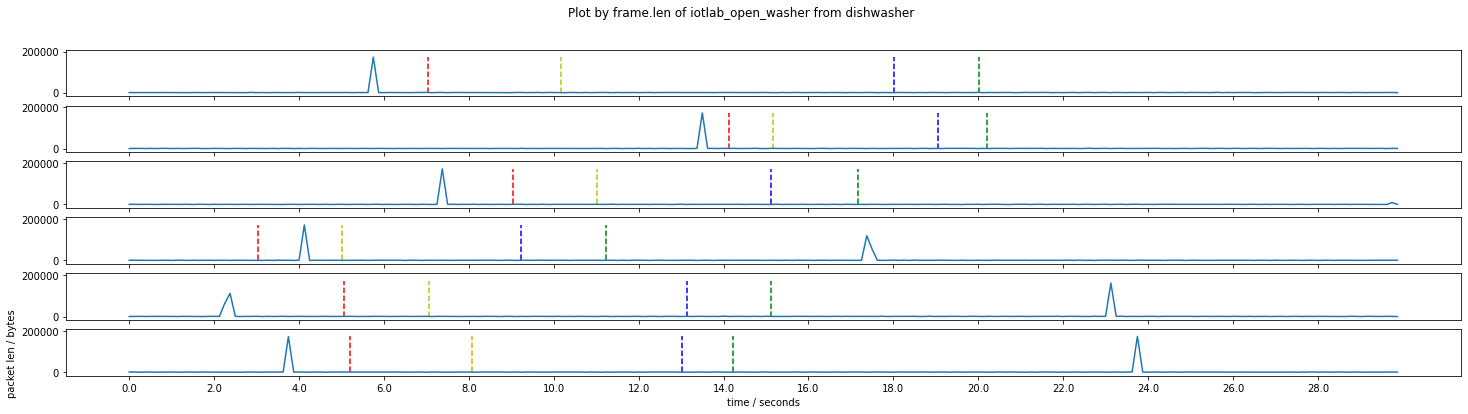

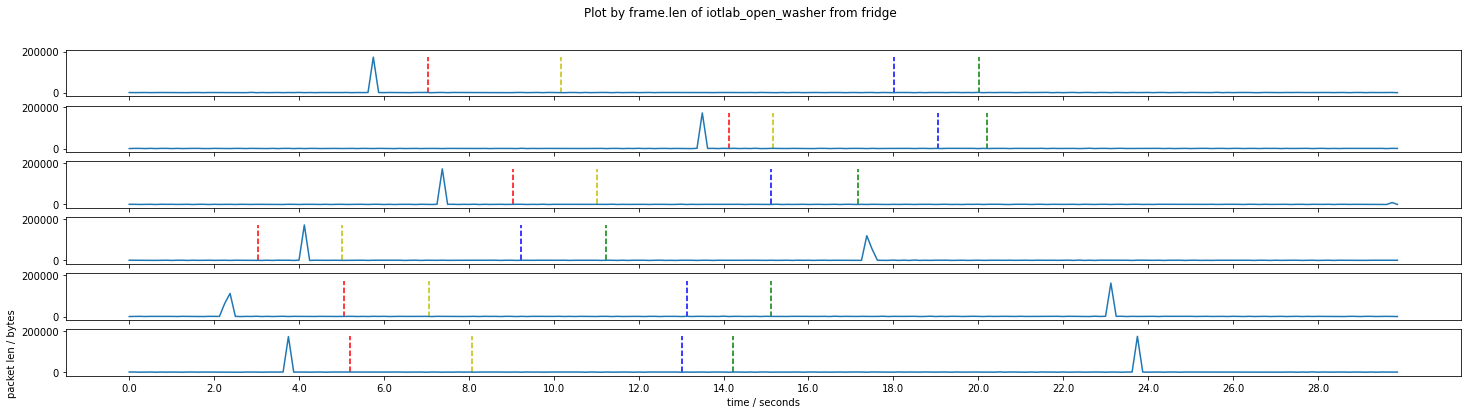

In [12]:
for activity in ['iotlab_open_washer', 'iotlab_open_dryer', 'iotlab_open_dishwasher','iotlab_open_fridge']:
    plot_vec_ip(col, 'iotlab_open_washer', '192.168.143.104', activity.split('_')[-1])

# Keypoint detection integrated

## Start with Fridge

In [61]:
import sys
import glob
import functools
from itertools import groupby

from deeplens.dataflow.map import Crop
from deeplens.struct import VideoStream
from deeplens.tracking.contour import *
from deeplens.utils.utils import overlay

frg_bbx = [372, 122, 572, 445]
bbx = frg_bbx


def find_episode(index, lst):
    fun = lambda x: x[1]-x[0]
    int_li = []
    for k, g in groupby(enumerate(lst), fun):
        l1 = [j for i, j in g]    # 连续数字的列表
        if len(l1) > 1:
            start = l1[0] * 1.0 / 24
            end = l1[-1] * 1.0 / 24
            
            row = [min(l1), max(l1), start, end, (end - start), index]
            int_li.append(row)
    epi_li = []
    
    if int_li:
        row = int_li[0]
        
        for p in range(len(int_li) - 1):
            if int_li[p+1][2] - row[3] < 1:
                row = [row[0], int_li[p+1][1], row[2], int_li[p+1][3], int_li[p+1][3] - row[2], index]
            else:
                epi_li.append(row)
                row = int_li[p+1]
            if p == len(int_li) - 2:
                epi_li.append(row)
    return epi_li


def kp_detection(file, bbx):
    src = file
    c = VideoStream(file, limit=-1)
    pipeline = c[Crop(bbx[0], bbx[1], bbx[2], bbx[3])][KeyPoints(blur=5, edge_low=500, edge_high=600, area_thresh=10, label="object")]

    count = []
    for frame in pipeline:
        if len(frame['bounding_boxes']) >= 1:
            # print((frame['frame'], len(frame['bounding_boxes'])))
            count.append(frame['frame'])

    #         img = overlay(frame['data'], frame['bounding_boxes'])
    #         plt.imshow(img)
    #         plt.title(frame['frame'])
    #         plt.show()
#     print(count)    
    return count


epi_li = [['Start_frame', 'End_frame', 'Start_ts', 'End_ts', 'Duration', 'Index']]
for file in glob.glob(data_path + 'iotlab_open_fridge/capture*/*.avi'):
    index = int(file.split('/')[-2].split('capture')[1].split('.seq')[0])
    count = kp_detection(file, bbx)
    for episode in find_episode(index, count):
        epi_li.append(episode) 
    
df_epi = pd.DataFrame(epi_li)
new_header = df_epi.iloc[0] #grab the first row for the header
df_epi = df_epi[1:] #take the data less the header row
df_epi.columns = new_header #set the header row as the df header

In [66]:
df_epi = df_epi.sort_values(by=['Index'])
df_epi.to_csv(data_path + 'iotlab_open_fridge/keypoint_episodes.csv', index=False)

## If serial movements detected on fridge, what's the classification result?

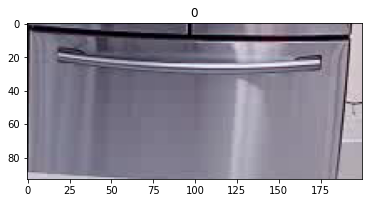

In [129]:
frg_bbx = [372, 122, 572, 445]
lower_door = [372, 352, 572, 445]
upper_door = [372, 122, 572, 352]
faucet_bbx = [382, 210, 437, 300]
bbx = lower_bbx
src = "/Users/shinanliu/Documents/Auto-labeling/iot/iotlab_devices/data/iotlab_open_fridge/capture0.seq/dzknetcaac0.mp4"
c = VideoStream(file, limit=-1)
pipeline = c[Crop(bbx[0], bbx[1], bbx[2], bbx[3])][KeyPoints(blur=5, edge_low=500, edge_high=600, area_thresh=10, label="object")]

count = []
for frame in pipeline:
    if len(frame['bounding_boxes']) >= 1:
        # print((frame['frame'], len(frame['bounding_boxes'])))
        count.append(frame['frame'])

    img = overlay(frame['data'], frame['bounding_boxes'])
    plt.imshow(img)
    plt.title(frame['frame'])
    plt.show()
    break
#     print(count)    
# return count


In [123]:
# Idle vs not Idle

## Get all bounding boxes
fridge_bbx = [372, 122, 572, 445]
faucet_bbx = [382, 210, 437, 300]
upper_bbx = [372, 122, 572, 352]
lower_bbx = [372, 352, 572, 445]

act_label = {"iotlab_idle": 0, 
             "iotlab_open_fridge": 1, 
             "iotlab_open_faucet_fridge": 2,
             "iotlab_open_lower_fridge": 3}

def kp_feature(file):
    kp_ft = []
    for bbx in [fridge_bbx, faucet_bbx, upper_bbx, lower_bbx]:
        kp_ft.append(len(kp_detection(file, bbx))*1.0/24)
#     kp_ft.append(index)
    return kp_ft

def save_kp_feature(activity):
    for file in glob.glob(data_path + activity + '/capture*/*.avi'):
        index = int(file.split('/')[-2].split('capture')[1].split('.seq')[0])
             
        out_dir = f'{feature_path}{activity}/keypoint/'
        out_des = open(out_dir + 'fridge-keypoint_' + str(index) + '.dat', 'wb')

        kp_ft = kp_feature(file)
        X = np.array(kp_ft)
        y = act_label[activity]
             
        data = X, y
        print(data)
        pickle.dump(data, out_des)

In [124]:
for activity in ["iotlab_idle", "iotlab_open_fridge", "iotlab_open_faucet_fridge", "iotlab_open_lower_fridge"]:
    save_kp_feature(activity)

(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0., 0., 0.]), 0)
(array([0., 0.

In [104]:
import os
def ft_str(activity):
    os.system('mkdir ' + feature_path + activity + '/keypoint')
    
# for path in glob.glob(data_path + 'iotlab_o*'):
#     activity = path.split('/')[-1]
#     print(activity)
#     ft_str(activity)
ft_str('iotlab_idle')

In [101]:


# df_epi.to_csv(data_path + 'iotlab_open_fridge/keypoint_episodes.csv', index=False)

act_li = ['iotlab_idle', 'iotlab_open_fridge', 'iotlab_open_lower_fridge', 'iotlab_open_faucet_fridge']
save_kp_feature()

,fridge,faucet,upper,lower,index
14,3.95833,0.125,3.95833,0,0
13,5.875,0.5,5.875,0,1
11,6.5,2.16667,6.5,0,2
12,7.79167,0.666667,7.70833,0.0833333,3
15,6.58333,3.66667,6.5,0.0833333,4
16,6.375,1.83333,6.375,0,5
18,5.95833,1.95833,5.875,0.0833333,6
17,4.20833,1.54167,4.20833,0,7
19,3.29167,1.25,3.29167,0,8
20,5.41667,2.20833,5.41667,0,9


In [125]:
import pickle
def load_data(in_file):
    with open(in_file, 'rb') as f:
        data = pickle.load(f)

    return data

vid_X, vid_y = load_data('/Users/shinanliu/Documents/Auto-labeling/iot/iotlab_devices/features/iotlab_idle/keypoint/fridge-keypoint_1.dat')
X, y = load_data('/Users/shinanliu/Documents/Auto-labeling/iot/iotlab_devices/features/iotlab_idle/netml-features/FFT-IAT/FFT-IAT_1.dat')

In [122]:
for x in X:
    print(x)

[0.014045 0.014045]
[0.16505003 0.16505003]
[0.01401997 0.01401997]
